# Sample grouping

Vamos nos deter no conceito de grupos de amostra. Como na seção anterior, daremos um exemplo para destacar alguns resultados surpreendentes. Desta vez, usaremos o conjunto de dados de dígitos manuscritos.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
data, target = digits.data, digits.target

Vamos recriar o mesmo modelo usado no exercício anterior: um classificador de regressão logística com pré-processador para dimensionar os dados.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

model = make_pipeline(StandardScaler(), LogisticRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Usaremos o mesmo modelo de linha de base. Usaremos uma `KFold` validação cruzada sem embaralhar(`shuffle`) os dados a princípio.

In [3]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, data, target, cv=cv,
                                          n_jobs=2)
print(f"The average accuracy is "
      f"{test_score_no_shuffling.mean():.3f} +/- "
      f"{test_score_no_shuffling.std():.3f}")

The average accuracy is 0.921 +/- 0.028


Agora, vamos repetir o experimento embaralhar(`shuffle`) os dados na validação cruzada.

In [4]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(model, data, target, cv=cv,
                                            n_jobs=2)
print(f"The average accuracy is "
      f"{test_score_with_shuffling.mean():.3f} +/- "
      f"{test_score_with_shuffling.std():.3f}")

The average accuracy is 0.968 +/- 0.003


Observamos que embaralhar(`shuffle`) os dados melhora a precisão média. Poderíamos ir um pouco mais longe e traçar a distribuição da pontuação do teste. Podemos primeiro concatenar as pontuações do teste.

In [5]:
import pandas as pd

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold without shuffling", "KFold with shuffling"],
).T

Vamos traçar a distribuição agora.

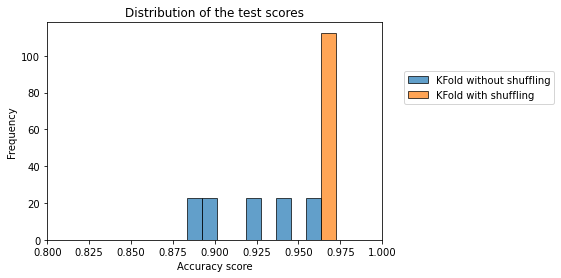

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

all_scores.plot.hist(bins=10, edgecolor="black", density=True, alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

O erro de teste de validação cruzada que usa `shuffe` tem menos variância do que aquele que não impõe `shuffe`. Isso significa que alguma dobra específica leva a uma pontuação baixa neste caso.

In [7]:
print(test_score_no_shuffling)

[0.92222222 0.88333333 0.94150418 0.96100279 0.89693593]


Portanto, há uma estrutura subjacente nos dados que o embaralhamento irá quebrar e obter melhores resultados. Para obter um melhor entendimento, devemos ler a documentação enviada com o conjunto de dados.

---

In [8]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Se lermos com atenção, 13 escritores escreveram os dígitos do nosso conjunto de dados, representando um total de 1797 amostras. Assim, um escritor escreveu várias vezes os mesmos números. Suponhamos que as amostras do escritor sejam agrupadas. Consequentemente, não embaralhar os dados manterá todas as amostras do gravador juntas no treinamento ou nos conjuntos de teste. A combinação dos dados quebrará essa estrutura e, portanto, os dígitos escritos pelo mesmo gravador estarão disponíveis nos conjuntos de treinamento e teste.

Além disso, um escritor normalmente tenderá a escrever dígitos da mesma maneira. Assim, nosso modelo aprenderá a identificar o padrão de um escritor para cada dígito, em vez de reconhecer o próprio dígito.

Podemos resolver esse problema garantindo que os dados associados a um gravador pertençam ao conjunto de treinamento ou teste. Portanto, queremos agrupar amostras para cada escritor.

Aqui, definiremos manualmente o grupo para os 13 escritores.

In [9]:
from itertools import count
import numpy as np

# defines the lower and upper bounds of sample indices
# for each writer
writer_boundaries = [0, 130, 256, 386, 516, 646, 776, 915, 1029,
                     1157, 1287, 1415, 1545, 1667, 1797]
groups = np.zeros_like(target)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

Podemos verificar o agrupamento traçando os índices vinculados aos ids do escritor.

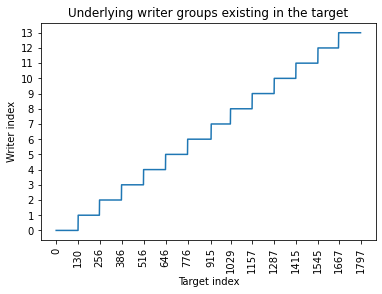

In [10]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Target index")
plt.ylabel("Writer index")
_ = plt.title("Underlying writer groups existing in the target")

Depois de agrupar os dígitos por escritor, podemos usar a validação cruzada para levar esta informação em consideração: a classe que contém `Group` deve ser usada.

In [11]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(model, data, target, groups=groups, cv=cv,
                             n_jobs=2)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- "
      f"{test_score.std():.3f}")

The average accuracy is 0.919 +/- 0.015


Vemos que essa estratégia é menos otimista em relação ao desempenho de generalização do modelo. No entanto, este é o mais confiável se nosso objetivo é tornar independentes os escritores de reconhecimento de dígitos manuscritos. Além disso, também podemos ver que o desvio padrão foi reduzido.

In [12]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=["KFold without shuffling", "KFold with shuffling",
           "KFold with groups"],
).T

In [14]:
display(all_scores)

,KFold without shuffling,KFold with shuffling,KFold with groups
0,0.922222,0.969444,0.925094
1,0.883333,0.972222,0.932990
2,0.941504,0.966574,0.891192
3,0.961003,0.963788,0.929319
4,0.896936,0.969359,0.914439


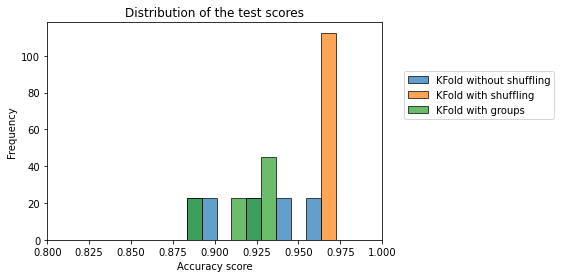

In [13]:
all_scores.plot.hist(bins=10, edgecolor="black", density=True, alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

Como conclusão, é realmente importante levar em consideração qualquer padrão de agrupamento de amostra ao avaliar um modelo. Caso contrário, os resultados obtidos serão excessivamente otimistas em relação à realidade.